In [4]:
import numpy as np, pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from WISE_tools import *
from scipy.stats import *
from astroML.time_series import ACF_EK

%matplotlib inline

# We're going to try to extract features from lightcurves that can be used to classify lightcurves. We're going to use 

In [2]:
unique_names = parse_source_names('test_data/')

J215803.09+485330.7


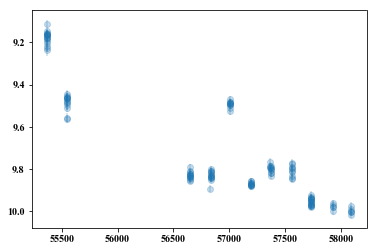

In [3]:
#Try accessing and concatenating lightcurves
for name in unique_names[1:]:
    print(name)
    
    df = get_lightcurve(name, 'test_data/')
    
    plt.errorbar(df['mjd'], df['w1mpro'], yerr=df['w1sigmpro'],
                 marker='o', linestyle='none', alpha=0.25)
plt.gca().invert_yaxis()

In [7]:
mjd,W1,W1err = df['mjd'].values, df['w1mpro'].values, df['w1sigmpro'].values

In [9]:
def extract_features(t, y, err):
    """
    Following Richards et al. (2011), calculates some summary statistics from the 
    lightcurves. TODO: output errors on all of these as well?

    Parameters
    ----------
    t : array-like
        times
    y : array-like
        magnitudes
    err : array-like
        errors on y
    
    Returns
    -------
    feature_list : list
        List of features that can be extracted from the lightcurve
    """
    
    #Feature 1: skew
    
    magskew = skew(y)
    
    #Feature 2: kurtosis
    
    magkurt = kurtosis(y)
    
    #Feature 3: standard deviation of mags
    
    magstd = np.std(y)
    
    #Feature 4: fraction of measurements >=1 std above/below mean
    
    z_scores = np.abs((y - np.mean(y))/magstd)
    beyond1std = len(z_scores[z_scores >= 1])/len(z_scores)
    
    #Feature 5: largest slope between two successive points
    dms = np.diff(y)
    dts = np.diff(t)
    
    maxslope = np.max(np.abs(dms/dts))
    
    #Feature 6: Range of data
    
    amplitude = np.max(y) - np.min(y)
    
    #Feature 7: median absolute deviation
    
    mad = np.median(np.abs(y - np.median(y)))
    
    #Feature 8: Median buffer range percentage
    
    buffer = np.abs((y - np.median(y))/amplitude)
    
    mbrf = len(buffer[buffer>= 0.1])/len(buffer)
    
    #Feature 9: fraction of y_i brighter than y_i-1 minus fraction y_i fainter than y_i-1
    
    bright_num = len(dms[dms <= 0])
    faint_num = len(dms[dms > 0])
    pair_slope_trend = (bright_num - faint_num)/len(dms)
    
    #Features 10-14: In flux: y-xth percentile range, scaled by 5-95th percentile range
    f = np.power(10.0,-0.4*y)
    range_mid_90 = np.percentile(f,95.0) - np.percentile(f,5.0)
    range_mid_80 = np.percentile(f,90.0) - np.percentile(f,10.0)
    range_mid_65 = np.percentile(f,82.5) - np.percentile(f,17.5)
    range_mid_50 = np.percentile(f,75.0) - np.percentile(f,25.0)
    range_mid_35 = np.percentile(f,67.5) - np.percentile(f,32.5)
    range_mid_20 = np.percentile(f,60.0) - np.percentile(f,40.0)
    
    flux_percentile_ratio_mid20 = range_mid_20 / range_mid_90
    flux_percentile_ratio_mid35 = range_mid_35 / range_mid_90
    flux_percentile_ratio_mid50 = range_mid_50 / range_mid_90
    flux_percentile_ratio_mid65 = range_mid_65 / range_mid_90
    flux_percentile_ratio_mid80 = range_mid_80 / range_mid_90
    
    #Feature 15: largest absolute departure from median flux, divided by median flux
    
    percent_amplitude = np.max(np.abs(f - np.median(f)))/np.median(f)
    
    #Feature 16: 5-95th percentile flux range over the median flux.
    
    percent_difference_flux_percentile = range_mid_90 / np.median(f)
    
    #Feature 17: rough approximation of autocorrelation time
    
    C_EK, C_EK_err, bins = ACF_EK(t, y, err, bins=np.linspace(0, (np.max(t)-np.min(t))/2, 50))
    t_EK = 0.5 * (bins[1:] + bins[:-1])
    #fit a line to C_EK vs. t_EK
    p = np.polyfit(t_EK[~np.isnan(C_EK)], C_EK[~np.isnan(C_EK)], deg=1, w=1/C_EK_err[~np.isnan(C_EK)])
    AC_time = (np.exp(-1) - p[1])/p[0]
    
    
    feature_list = [magskew, magkurt, magstd, beyond1std, maxslope, amplitude, mad, mbrf, 
            pair_slope_trend, flux_percentile_ratio_mid20, flux_percentile_ratio_mid35,
            flux_percentile_ratio_mid50, flux_percentile_ratio_mid65, 
            flux_percentile_ratio_mid80, percent_amplitude, percent_difference_flux_percentile,
            AC_time]
    
    return feature_list

In [10]:
extract_features(mjd, W1, W1err)

/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:133: RuntimeWarning: invalid value encountered in true_divide
  ACF /= M
/Users/carina/anaconda/lib/python3.5/site-packages/astroML/time_series/ACF.py:135: RuntimeWarning: divide by zero encountered in true_divide
  return ACF, np.sqrt(2. / M), bins


[-0.9538278579233433,
 -0.3977161700450247,
 0.26312666108954447,
 0.23308270676691728,
 811.0236262728968,
 0.9049999999999994,
 0.125,
 0.5413533834586466,
 -0.030303030303030304,
 0.0365684967024534,
 0.10361797463206097,
 0.4195021982035201,
 0.5101029754973041,
 0.9409767621621841,
 0.9142559250210858,
 0.9629716745857481,
 428.21234833772303]

In [11]:
#This isn't too hard to calculate. What if we use someone else's python library?
#FATS: FEATURE ANALYSIS FOR TIME SERIES, Nun et al. (2015), arXiv:1506.00010